In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/brain-mri-images-for-brain-tumor-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 1.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/26 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N26.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N5.jpg
/kaggle/input/brain-mri-images-for-b

CNN model

In [3]:
import os
from pathlib import Path
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix

# Dataset paths
YES_DIR = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes"
NO_DIR  = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no"

# Verify folders exist
for p in (YES_DIR, NO_DIR):
    if not os.path.exists(p):
        raise FileNotFoundError(f"Path not found: {p}")

# Settings
SEED = 42
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 12

# Create train/val split manually
from shutil import copy2, rmtree

tmp_root = Path("/tmp/brain_mri_split")
if tmp_root.exists():
    rmtree(tmp_root)

train_dir = tmp_root / "train"
val_dir   = tmp_root / "val"

(train_dir/"yes").mkdir(parents=True)
(train_dir/"no").mkdir(parents=True)
(val_dir/"yes").mkdir(parents=True)
(val_dir/"no").mkdir(parents=True)

yes_images = list(Path(YES_DIR).glob("*"))
no_images  = list(Path(NO_DIR).glob("*"))

random.shuffle(yes_images)
random.shuffle(no_images)

def split_copy(images, train_d, val_d):
    split = int(len(images)*0.8)
    for i, img in enumerate(images):
        copy2(img, train_d if i < split else val_d)

split_copy(yes_images, train_dir/"yes", val_dir/"yes")
split_copy(no_images,  train_dir/"no",  val_dir/"no")

# NO AUGMENTATION
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

# Model with NO DROPOUT, NO AUGMENTATION
def build_model():
    model = models.Sequential([
        layers.Input(shape=IMG_SIZE+(3,)),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_model()
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(train_gen, epochs=EPOCHS, validation_data=val_gen, verbose=2)

# Predictions
val_gen.reset()
preds = model.predict(val_gen)
y_pred = (preds.ravel() >= 0.5).astype(int)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# PRINT CLASSIFICATION REPORT ONLY
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\n\n===== CLASSIFICATION REPORT (No Augmentation, No Dropout) =====\n")
print(report)


Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 - 7s - 991ms/step - accuracy: 0.6485 - loss: 0.6068 - val_accuracy: 0.7059 - val_loss: 0.5993
Epoch 2/12
7/7 - 5s - 669ms/step - accuracy: 0.7871 - loss: 0.5032 - val_accuracy: 0.7255 - val_loss: 0.6490
Epoch 3/12
7/7 - 6s - 896ms/step - accuracy: 0.7871 - loss: 0.4898 - val_accuracy: 0.7255 - val_loss: 0.5695
Epoch 4/12
7/7 - 5s - 662ms/step - accuracy: 0.7871 - loss: 0.4702 - val_accuracy: 0.7451 - val_loss: 0.5461
Epoch 5/12
7/7 - 5s - 643ms/step - accuracy: 0.7970 - loss: 0.4411 - val_accuracy: 0.7451 - val_loss: 0.5640
Epoch 6/12
7/7 - 5s - 734ms/step - accuracy: 0.8168 - loss: 0.4270 - val_accuracy: 0.7647 - val_loss: 0.5272
Epoch 7/12
7/7 - 5s - 742ms/step - accuracy: 0.8119 - loss: 0.4034 - val_accuracy: 0.7843 - val_loss: 0.5253
Epoch 8/12
7/7 - 5s - 646ms/step - accuracy: 0.8366 - loss: 0.3807 - val_accuracy: 0.7451 - val_loss: 0.5140
Epoch 9/12
7/7 - 4s - 642ms/step - accuracy: 0.8366 - loss: 0.3567 - val_accuracy: 0.7843 - val_loss: 0.5240
Epoch 10/12
7/7 - 5s - 644ms/s

In [5]:
import os
import random
import numpy as np
from pathlib import Path
from shutil import copy2, rmtree

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ============================================================
# 1. Load dataset paths
# ============================================================

yes_dir = Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes")
no_dir  = Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection/no")

yes_images = list(yes_dir.glob("*"))
no_images  = list(no_dir.glob("*"))

print("Total YES images:", len(yes_images))
print("Total NO images :", len(no_images))

# ============================================================
# 2. Select up to 100 images safely
# ============================================================

random.seed(42)

yes_count = min(100, len(yes_images))
no_count  = min(100, len(no_images))

yes_sel = random.sample(yes_images, yes_count)
no_sel  = random.sample(no_images, no_count)

print(f"\nUsing {yes_count} images for YES class")
print(f"Using {no_count} images for NO class\n")

# ============================================================
# 3. Create 80/20 train/val split
# ============================================================

root = Path("/tmp/brain_mri_100samples")
if root.exists():
    rmtree(root)

train_dir = root / "train"
val_dir   = root / "val"

(train_dir/"yes").mkdir(parents=True)
(train_dir/"no").mkdir(parents=True)
(val_dir/"yes").mkdir(parents=True)
(val_dir/"no").mkdir(parents=True)

def split_copy(images, label):
    split = int(0.8 * len(images))
    for i, img in enumerate(images):
        target = train_dir/label if i < split else val_dir/label
        copy2(img, target/img.name)

split_copy(yes_sel, "yes")
split_copy(no_sel,  "no")

print("Train YES:", len(list((train_dir/'yes').glob('*'))))
print("Train NO :", len(list((train_dir/'no').glob('*'))))
print("Val YES :", len(list((val_dir/'yes').glob('*'))))
print("Val NO  :", len(list((val_dir/'no').glob('*'))))

# ============================================================
# 4. Data generators
# ============================================================

IMG_SIZE = (128,128)
BATCH = 16

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH, class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH, class_mode='binary', shuffle=False
)

# ============================================================
# 5. CNN model (No Augmentation, No Dropout)
# ============================================================

def build_model():
    model = models.Sequential([
        layers.Input(shape=IMG_SIZE+(3,)),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_model()
model.compile(optimizer=optimizers.Adam(1e-4), 
              loss="binary_crossentropy",
              metrics=["accuracy"])

# ============================================================
# 6. Train
# ============================================================

history = model.fit(train_gen, epochs=12, validation_data=val_gen, verbose=2)

# ============================================================
# 7. Evaluate
# ============================================================

val_gen.reset()
preds = model.predict(val_gen)
y_pred = (preds.ravel() >= 0.5).astype(int)
y_true = val_gen.classes

class_names = list(val_gen.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_names)
print("\n===== CLASSIFICATION REPORT =====\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\n===== CONFUSION MATRIX =====\n")
print(cm)


Total YES images: 155
Total NO images : 98

Using 100 images for YES class
Using 98 images for NO class

Train YES: 80
Train NO : 78
Val YES : 20
Val NO  : 20
Found 158 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 - 6s - 556ms/step - accuracy: 0.5949 - loss: 0.6578 - val_accuracy: 0.7500 - val_loss: 0.5654
Epoch 2/12
10/10 - 3s - 347ms/step - accuracy: 0.6962 - loss: 0.5949 - val_accuracy: 0.8250 - val_loss: 0.4858
Epoch 3/12
10/10 - 5s - 519ms/step - accuracy: 0.7722 - loss: 0.5289 - val_accuracy: 0.8500 - val_loss: 0.4604
Epoch 4/12
10/10 - 4s - 356ms/step - accuracy: 0.7658 - loss: 0.4923 - val_accuracy: 0.7750 - val_loss: 0.4671
Epoch 5/12
10/10 - 3s - 346ms/step - accuracy: 0.7848 - loss: 0.4634 - val_accuracy: 0.8750 - val_loss: 0.4384
Epoch 6/12
10/10 - 3s - 339ms/step - accuracy: 0.8038 - loss: 0.4296 - val_accuracy: 0.8500 - val_loss: 0.4353
Epoch 7/12
10/10 - 3s - 343ms/step - accuracy: 0.8165 - loss: 0.3964 - val_accuracy: 0.8000 - val_loss: 0.4939
Epoch 8/12
10/10 - 3s - 349ms/step - accuracy: 0.8354 - loss: 0.3669 - val_accuracy: 0.8750 - val_loss: 0.3898
Epoch 9/12
10/10 - 5s - 515ms/step - accuracy: 0.8608 - loss: 0.3219 - val_accuracy: 0.8500 - val_loss: 0.3997
Epoch 10/12


Brier score: 0.1255
ROC AUC: 0.9325
Average Precision (AP): 0.9557


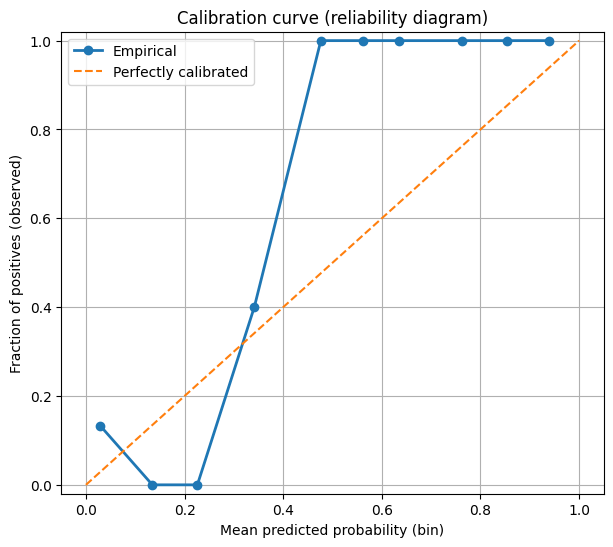

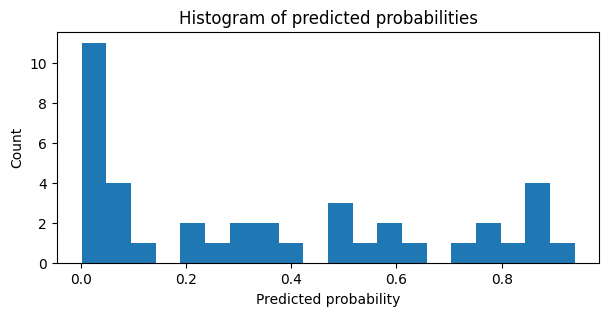

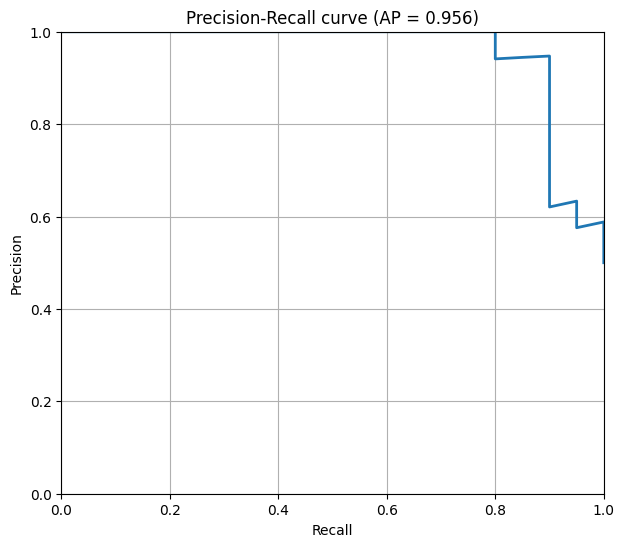

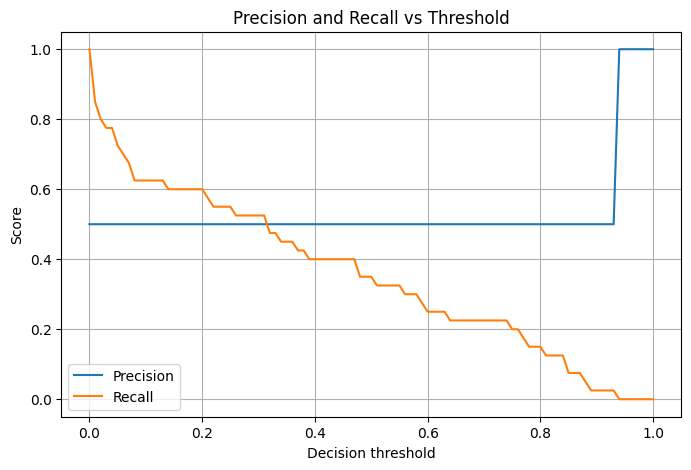


Confusion matrix at threshold 0.5:
[[520 280]
 [520 280]]
Precision@0.5 = 0.500
Recall@0.5    = 0.350
F1@0.5        = 0.412


In [7]:
# Calibration + Precision-Recall + Precision/Recall vs Threshold plots
# Run this cell after training. It expects: model, val_gen, history (optional).
# If preds / y_true are missing it will recompute them.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, brier_score_loss, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# ---- ensure preds and y_true exist ----
if 'val_gen' not in globals():
    raise RuntimeError("val_gen is not defined in the notebook. Run the evaluation cell that creates val_gen first.")

# get predicted probabilities if needed
if 'preds' not in globals():
    print("Computing preds = model.predict(val_gen) ...")
    val_gen.reset()
    preds = model.predict(val_gen)  # shape (n_samples,1) or (n,)
    preds = np.array(preds).ravel()

# get true labels if needed
if 'y_true' not in globals():
    if hasattr(val_gen, 'classes'):
        y_true = np.array(val_gen.classes)
    else:
        raise RuntimeError("y_true not found and val_gen.classes not available.")

# basic checks
assert preds.shape[0] == y_true.shape[0], f"preds ({preds.shape[0]}) and y_true ({y_true.shape[0]}) lengths differ."

# useful metrics
brier = brier_score_loss(y_true, preds)
try:
    roc_auc = roc_auc_score(y_true, preds)
except Exception:
    roc_auc = None
ap = average_precision_score(y_true, preds)

print(f"Brier score: {brier:.4f}")
if roc_auc is not None:
    print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision (AP): {ap:.4f}")

# -----------------------
# 1) Calibration (Reliability) Curve
# -----------------------
prob_true, prob_pred = calibration_curve(y_true, preds, n_bins=10, strategy='uniform')

plt.figure(figsize=(7,6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Empirical')
plt.plot([0,1],[0,1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration curve (reliability diagram)')
plt.xlabel('Mean predicted probability (bin)')
plt.ylabel('Fraction of positives (observed)')
plt.ylim([-0.02,1.02])
plt.grid(True)
plt.legend()
plt.show()

# histogram of predicted probabilities
plt.figure(figsize=(7,3))
plt.hist(preds, bins=20)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.show()

# -----------------------
# 2) Precision-Recall Curve
# -----------------------
precision, recall, pr_thresholds = precision_recall_curve(y_true, preds)
# precision_recall_curve returns thresholds of length len(precision)-1

plt.figure(figsize=(7,6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {ap:.3f})')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# -----------------------
# 3) Precision and Recall vs Threshold
# -----------------------
# build thresholds in the same orientation as pr_thresholds
# pr_thresholds corresponds to points where precision/recall change
# For plotting vs threshold, we'll compute curves for many thresholds.
threshs = np.linspace(0,1,101)
prec_at_t = []
rec_at_t = []
for t in threshs:
    y_pred_t = (preds >= t).astype(int)
    # avoid division by zero
    tp = int(((y_pred_t==1) & (y_true==1)).sum())
    fp = int(((y_pred_t==1) & (y_true==0)).sum())
    fn = int(((y_pred_t==0) & (y_true==1)).sum())
    prec = tp / (tp + fp) if (tp+fp) > 0 else 1.0
    rec  = tp / (tp + fn) if (tp+fn) > 0 else 0.0
    prec_at_t.append(prec)
    rec_at_t.append(rec)

plt.figure(figsize=(8,5))
plt.plot(threshs, prec_at_t, label='Precision')
plt.plot(threshs, rec_at_t, label='Recall')
plt.xlabel('Decision threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

# -----------------------
# 4) Quick single-number summary at default threshold 0.5
# -----------------------
y_pred_05 = (preds >= 0.5).astype(int)
tp = int(((y_pred_05==1) & (y_true==1)).sum())
fp = int(((y_pred_05==1) & (y_true==0)).sum())
tn = int(((y_pred_05==0) & (y_true==0)).sum())
fn = int(((y_pred_05==0) & (y_true==1)).sum())

print("\nConfusion matrix at threshold 0.5:")
print(np.array([[tn, fp],[fn, tp]]))
print(f"Precision@0.5 = {tp/(tp+fp) if (tp+fp)>0 else 0.0:.3f}")
print(f"Recall@0.5    = {tp/(tp+fn) if (tp+fn)>0 else 0.0:.3f}")
print(f"F1@0.5        = {2*tp/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0.0:.3f}")


Using the trained model from memory...

Choose testing method:
1. Upload file (Colab) - Run: test_with_upload_colab()
2. Enter file path - Run: test_with_path()
3. Test with sample - Run: test_with_existing()

Or directly use: predict_tumor('your_image_path.jpg')

TESTING WITH SAMPLE IMAGES FROM VALIDATION SET


Enter image path or type 'sample' to use validation image:  /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y106.jpg


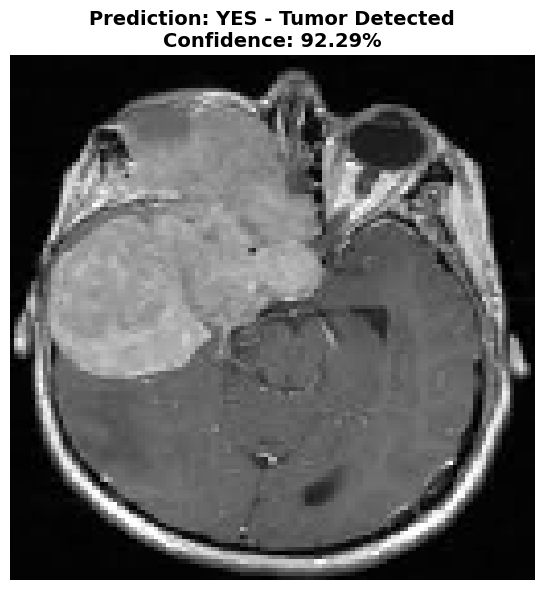


Prediction: YES - Tumor Detected
Confidence: 92.29%
Raw score: 0.9229 (>=0.5 means tumor detected)


In [22]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# Load the trained model
# ============================================================

# NOTE: Make sure 'model' variable exists from your training script
# This script should be run in the SAME notebook after training
# OR load a saved model: model = load_model('brain_tumor_model.h5')

print("Using the trained model from memory...")

# ============================================================
# Test function for single image
# ============================================================

def predict_tumor(img_path, show_image=True):
    """
    Predict if an MRI image contains a tumor
    
    Args:
        img_path: Path to the image file
        show_image: Whether to display the image
    
    Returns:
        prediction: 'YES - Tumor Detected' or 'NO - No Tumor'
        confidence: Confidence score (0-100%)
    """
    IMG_SIZE = (128, 128)
    
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    confidence = prediction[0][0]
    
    # Interpret result
    if confidence >= 0.5:
        result = "YES - Tumor Detected"
        conf_percent = confidence * 100
    else:
        result = "NO - No Tumor"
        conf_percent = (1 - confidence) * 100
    
    # Display the image with prediction
    if show_image:
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Prediction: {result}\nConfidence: {conf_percent:.2f}%', 
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    print(f"\nPrediction: {result}")
    print(f"Confidence: {conf_percent:.2f}%")
    print(f"Raw score: {confidence:.4f} (>=0.5 means tumor detected)")
    
    return result, conf_percent

# ============================================================
# Upload and test an image
# ============================================================

# Method 1: For Google Colab
def test_with_upload_colab():
    from google.colab import files
    print("Click 'Choose Files' to upload an image...")
    uploaded = files.upload()
    
    for filename in uploaded.keys():
        print(f"\n{'='*60}")
        print(f"Testing: {filename}")
        print('='*60)
        predict_tumor(filename)

# Method 2: For Kaggle - Use file from input or manual path
def test_with_path():
    img_path = input("Enter the full path to your image: ")
    predict_tumor(img_path)

# Method 3: Test with existing validation images
def test_with_existing():
    """Test with images from the dataset"""
    test_img = input("Enter image path or type 'sample' to use validation image: ")
    
    if test_img.lower() == 'sample':
        # Use a random image from validation set
        val_yes = list(Path("/tmp/brain_mri_100samples/val/yes").glob("*"))
        val_no = list(Path("/tmp/brain_mri_100samples/val/no").glob("*"))
        
        if val_yes:
            print("\nTesting sample YES image...")
            predict_tumor(str(val_yes[0]))
        if val_no:
            print("\nTesting sample NO image...")
            predict_tumor(str(val_no[0]))
    else:
        predict_tumor(test_img)

# Choose your method:
print("\nChoose testing method:")
print("1. Upload file (Colab) - Run: test_with_upload_colab()")
print("2. Enter file path - Run: test_with_path()")
print("3. Test with sample - Run: test_with_existing()")
print("\nOr directly use: predict_tumor('your_image_path.jpg')")

# Auto-run for Kaggle - test with existing sample
print("\n" + "="*60)
print("TESTING WITH SAMPLE IMAGES FROM VALIDATION SET")
print("="*60)
test_with_existing()

# ============================================================
# Batch testing on multiple images
# ============================================================

def test_multiple_images(image_folder):
    """
    Test multiple images from a folder
    
    Args:
        image_folder: Path to folder containing test images
    """
    image_folder = Path(image_folder)
    image_files = list(image_folder.glob("*.jpg")) + list(image_folder.glob("*.png"))
    
    print(f"\nTesting {len(image_files)} images...\n")
    print("="*60)
    
    results = []
    for img_path in image_files:
        print(f"\nImage: {img_path.name}")
        result, confidence = predict_tumor(img_path, show_image=False)
        results.append({
            'filename': img_path.name,
            'prediction': result,
            'confidence': confidence
        })
        print("-"*60)
    
    # Summary
    tumor_count = sum(1 for r in results if 'YES' in r['prediction'])
    print(f"\n{'='*60}")
    print(f"SUMMARY:")
    print(f"Total images tested: {len(results)}")
    print(f"Tumor detected: {tumor_count}")
    print(f"No tumor: {len(results) - tumor_count}")
    print(f"{'='*60}")
    
    return results

# Example usage for batch testing:
# results = test_multiple_images("/path/to/test/folder")

# ============================================================
# Interactive testing (for Jupyter/Colab)
# ============================================================

def interactive_test():
    """
    Interactive testing - prompts for image path
    """
    while True:
        img_path = input("\nEnter image path (or 'quit' to exit): ")
        if img_path.lower() == 'quit':
            break
        
        try:
            predict_tumor(img_path)
        except Exception as e:
            print(f"Error: {e}")
            print("Please check the file path and try again.")

# Uncomment to use interactive mode:
# interactive_test()